In [4]:
import os
import torch
from torch import nn
from PIL import Image
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from clipseg_model import CLIPSeg
from data.cub_parts_dataset import CUBPartsDataset, collate_fn

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Dataset

## CUB Parts

In [5]:
dataset_train = CUBPartsDataset('datasets/PASCUB', split='train')

In [6]:
im_path, gt_path, im, gt = dataset_train[2]
print(gt.unique())
im

tensor([0, 1, 2, 3, 4, 5, 6, 7])


tensor([[[119, 119, 118,  ..., 125, 126, 127],
         [118, 117, 117,  ..., 126, 127, 127],
         [118, 117, 117,  ..., 128, 128, 128],
         ...,
         [133, 133, 133,  ..., 130, 130, 130],
         [132, 132, 133,  ..., 130, 130, 130],
         [132, 132, 132,  ..., 130, 130, 132]],

        [[134, 134, 134,  ..., 139, 140, 141],
         [133, 133, 133,  ..., 140, 141, 141],
         [133, 133, 133,  ..., 142, 142, 142],
         ...,
         [150, 150, 150,  ..., 150, 150, 150],
         [149, 149, 150,  ..., 150, 150, 150],
         [149, 149, 149,  ..., 150, 150, 149]],

        [[167, 167, 167,  ..., 166, 167, 168],
         [166, 166, 166,  ..., 167, 168, 168],
         [166, 166, 166,  ..., 169, 169, 169],
         ...,
         [176, 176, 176,  ..., 175, 175, 175],
         [175, 175, 176,  ..., 175, 175, 175],
         [175, 175, 175,  ..., 175, 175, 175]]], dtype=torch.uint8)

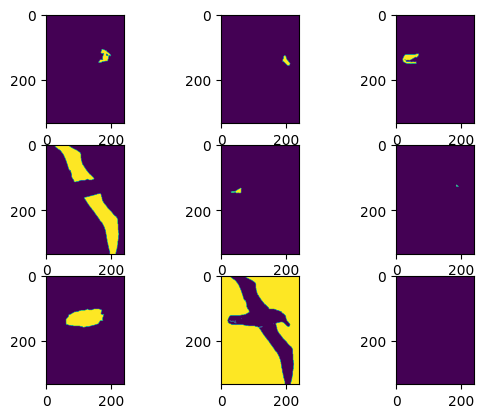

In [7]:
fig, axes = plt.subplots(3,3)
gt_np = gt.numpy()
for i, ax in enumerate(axes.flatten()):
    ax.imshow((gt_np == i).astype(int))

# CLIPSeg

In [8]:
clip_seg = CLIPSeg()
state_dict = torch.load('checkpoints/clipseg_ft_VA_L_F_D_voc.pth', map_location='cpu')
clip_seg.load_state_dict(state_dict['model'])

Some weights of CLIPSegForImageSegmentation were not initialized from the model checkpoint at CIDAS/clipseg-rd64-refined and are newly initialized: ['non_object_embedding', 'text_adapter.fc.0.weight', 'text_adapter.fc.2.weight', 'tunable_linear.weight', 'visual_adapter.fc.0.weight', 'visual_adapter.fc.2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

In [9]:
dataloader_train = DataLoader(dataset=dataset_train, batch_size=4, shuffle=False, collate_fn=collate_fn)
dataloader_train_iter = iter(dataloader_train)

In [28]:
# inference
batch = next(dataloader_train_iter)
clip_seg.eval()
with torch.no_grad():
    results = clip_seg(batch)

In [29]:
# train
batch = next(dataloader_train_iter)
clip_seg.train()
loss = clip_seg(batch)
loss

{'loss_sem_seg': tensor(1.3658, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)}

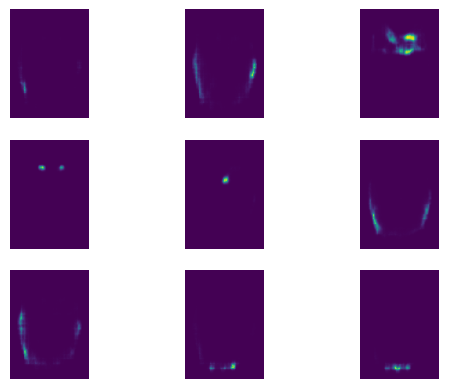

In [25]:
gif, axes = plt.subplots(3, 3)
for score_map, ax in zip(results[0]['sem_seg'], axes.flatten()):
    ax.imshow(score_map)
    ax.axis('off')

In [13]:
results[0]['sem_seg'].shape

torch.Size([9, 349, 461])

In [17]:
batch[2][0].shape

torch.Size([3, 349, 461])

In [18]:
results[0]['sem_seg'].shape

torch.Size([9, 349, 461])

In [27]:
batch[0]

('datasets/PASCUB/PASCAL_Parts/images_train/2010_005968_1.png',
 'datasets/PASCUB/PASCAL_Parts/images_train/2010_004252_1.png',
 'datasets/PASCUB/PASCAL_Parts/images_train/2009_002256_1.png',
 'datasets/PASCUB/PASCAL_Parts/images_train/2010_005217_1.png')

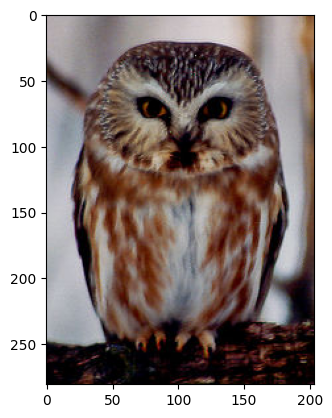

In [26]:
plt.imshow(batch[2][0].permute(1,2,0))

In [ ]:
gt_maps = batch[1][0]
fig, axes = plt.subplots(3,3)
gt_np = gt_maps.numpy()
for i, ax in enumerate(axes.flatten()):
    ax.imshow((gt_np == i).astype(int))

In [32]:
for n, w in clip_seg.named_parameters():
    print(n, type(w))

clipseg_model.non_object_embedding <class 'torch.nn.parameter.Parameter'>
clipseg_model.clip.logit_scale <class 'torch.nn.parameter.Parameter'>
clipseg_model.clip.text_model.embeddings.token_embedding.weight <class 'torch.nn.parameter.Parameter'>
clipseg_model.clip.text_model.embeddings.position_embedding.weight <class 'torch.nn.parameter.Parameter'>
clipseg_model.clip.text_model.encoder.layers.0.self_attn.k_proj.weight <class 'torch.nn.parameter.Parameter'>
clipseg_model.clip.text_model.encoder.layers.0.self_attn.k_proj.bias <class 'torch.nn.parameter.Parameter'>
clipseg_model.clip.text_model.encoder.layers.0.self_attn.v_proj.weight <class 'torch.nn.parameter.Parameter'>
clipseg_model.clip.text_model.encoder.layers.0.self_attn.v_proj.bias <class 'torch.nn.parameter.Parameter'>
clipseg_model.clip.text_model.encoder.layers.0.self_attn.q_proj.weight <class 'torch.nn.parameter.Parameter'>
clipseg_model.clip.text_model.encoder.layers.0.self_attn.q_proj.bias <class 'torch.nn.parameter.Param

In [35]:
'.jpg'.replace('jpg', 'png')

'.png'